## Polynomial chaos expansions

Polynomial Chaos (PC) expansions have risen as efficient means of representing stochastic processes with the intention of quantifying uncertainty in differential equations. PC expansions are based on a probabilistic framework and represent stochastic quantities as spectral expansions of orthogonal polynomials.

Thus, we can summarize the polynomial chaos expansion has an advanced polynomial chaos method for dealing with problematic random variables. 

Let $u(x,\omega)$ be a random process, then we can rewrite it as a polynomial chaos expansion

\begin{align*}
        u(x,\omega) &= \sum_{i=0}^\infty u_i(x)\phi_i(\epsilon),\quad \epsilon\in\mathbb{R}^d
\end{align*}

where $u_i(x)$ are deterministic coefficients, $\epsilon$ are random variables, and  $\{\Phi_j(\epsilon) | j = 0, 1, ...\}$ is a family of orthogonal polynomials, often referred to as the orthogonal polynomial basis, satisfying

$$
\langle \Phi_m(\epsilon), \Phi_n(\epsilon) \rangle = \int_{\mathbb{R}} \Phi_m(\epsilon) \Phi_n(\epsilon) w(\epsilon) \, d\epsilon = \gamma_m \delta_{mn}, 
$$

where the inner product is defined with respect to some weighting function $w(\epsilon)$ and $\gamma_m$ is a normalization constant.

The weighting function, $w(\epsilon)$, is often chosen to be a probability density function, and certain classes of polynomials are orthogonal with respect to well-known probability density functions. Examples of orthogonal polynomials (and the distribution, or germ, corresponding to their weighting functions) include Legendre (uniform), Hermite (Gaussian), and Leguerre (exponential or Gamma) polynomials.


### Cameron-Martin Theorem

<details>
  <summary><b> Cameron-Martin Theorem</b> (Cameron & Martin, 1947)</summary>

---

For any functional $ f $ in a Hilbert measure space $ (\mathcal{X} , \mathcal{M}, \mu) $, there exist a set of polynomials $ \{\phi_i\} $ and constants $ \{a_i\} $ such that

$$
\lim_{n\rightarrow\infty}\int_{\mathcal{X}}(f(x) - \hat{f}_n(x))^2d\mu = 0
$$

where $ \hat{f}_n(x) = \sum_{i=0}^n a_i\Phi_i(x) $ and $ a_i $ is obtained from the Galerkin projection $ a_i = \frac{\langle f, \Phi_i \rangle}{\|\Phi_i\|^2} $.

The proof of this result is not trivial (interested readers are referred to Cameron & Martin, 1947). The rate of convergence depends on the smoothness of the function $ f $ and the type of orthogonal polynomial basis functions $ \{\phi_i\} $ used for approximation, and this subject has been heavily studied (e.g., see Newman & Raymon, 1969; Xiu, 2010). The limiting behavior of the approximation error $ \|f - \hat{f}\| $ is $ O(N^{-p}) $ where $ p $ denotes the differentiability of the function $ f: X \rightarrow Y $ and $ O(\epsilon) $ (recall that $ O(\epsilon) \rightarrow 0 $ as $ \epsilon \rightarrow 0 $). For an analytic function $ f $, the convergence rate is exponential, i.e. $ \|f - \hat{f}\| $ is $ O(e^{-\alpha N}) $ for some constant $ \alpha > 0 $.

</details>


By the Cameron-Martin theorem, the PCE converges to a $ L^2 $ functional in the $ L^2 $ sense, thus we can truncate to $ P $ terms, 

$$
u(x,\omega) = \sum_{i=0}^P u_i(x)\phi_i(\epsilon),\quad \epsilon\in\mathbb{R}^d
$$

This saves a lot in computational cost, and is one of the main advantages with respect to MCMC methods. 

The value of $ P $ is determined by the number $ d $ of random variables and the highest degree of polynomial $ K $ used to represent $ u $ with the formula

$$
P + 1 = \frac{(d+K)!}{d!K!}
$$


### Advantages

**Versatility**

By changing

* diamension of $\epsilon\in\mathbb{R}^d$;
* polynomial order approximation;
* Coefficient values
can come really close to any distribution. 

Additionally, thanks to the orthogonality of $\{\phi_i\}$, the expected value and variance of $u(x,\omega)$ can be expressed as:
$$
\mathbb{E}(u) = u_0, \quad \text{Var}(u) = \sum_{i=1}^P u_i^2\mathbb{E}(\phi_i^2).
$$


<details>
  <summary><b>Show</b> </summary>

---
When the weighting function in the inner product is a probability density function and the orthogonal polynomials are normalized such that $\Phi_0(\epsilon) = 1$, we can directly use the inner products to calculate expected values, since $\langle \cdot \rangle = \mathbb{E}[\cdot]$. This gives us

$$
\begin{align*}
\mathbb{E}[u(\epsilon)] \approx 
&= \mathbb{E}[u(\epsilon)\Phi_0(\epsilon)] \\
&= \sum_{j=0}^{P} \mathbb{E}[u_j\Phi_j(\epsilon)\Phi_0(\epsilon)] \\
&= u_0,
\end{align*}
$$

since $\langle \Phi_0^2(X) \rangle = 1$, and we see that $E[u(\epsilon)] \approx u_0$. Note that this is a general result and holds regardless of the class of orthogonal polynomials used. Similarly, we can compute the variance (for full steps see [constantine2007primer]).
</details>

### Example

Lets construct a polynomial chaos expansion of $f(Z) = Z$, where $Z \sim N(0,1)$. Since the random variable is normally distributed, we will use the Hermite basis,

In [35]:
import numpy as np 
from matplotlib import pyplot as plt
import chaospy as cp
from ipywidgets import interact, widgets
import numpy.polynomial.hermite_e as herm
from scipy.integrate import quad
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import beta
import math
import warnings
warnings.filterwarnings("ignore")

In [36]:
# Hermite polynomial: H_n(x)
def H(z, n):
    return herm.hermeval(z, n*[0]+[1])

#  Numerical calculation of < H_m(z) H_n(z) > inner product
def inner_prod(m, n):
    f = lambda z : H(z, n) * H(z, m) * norm.pdf(z)
    return quad(f, -np.inf, np.inf)[0]

def inner_prod(m, n):
    return 0 if m != n else math.factorial(n)

# Numerical calculation of < f(x) H_m(x) > inner product
def inner_prod_func(f, m, dom =[-100, 100]):
    if dom is None:
        dom = [-np.inf, np.inf]
    h = lambda z : f(z) * H(z, m) * norm.pdf(z)
    return quad(h, dom[0], dom[1])[0]

# Calculate the a_j coefficients
def find_coef(f, p=10, dom=[-100, 100]):
    a = []
    for i in range(p):
        ip = inner_prod(i, i)
        ipf = inner_prod_func(f, i, dom)
        a.append(ipf/ip)
    return a

# Calculate f(z) given a_i, ..., a_p
def eval_poly(z, a):
    f = 0.0
    for i in range(len(a)):
        f += a[i] * H(z, i)
    return f

# Mean
def mean(a):
    return a[0]

# Variance
def var(a):
    total = 0.0
    for i in range(1, len(a)):
        total += (a[i]**2) * inner_prod(i, i)
    return total



In [38]:
def interactive_plot(p):
    f = lambda z: z
    
    # Calculate coefficients based on the input p
    a = find_coef(f, p)
    
    # Generate random data or use existing data
    Z = np.random.randn(10000)
    
    # Calculate f_tilde
    f_tilde = [eval_poly(z, a) for z in Z]
    
    # Plot histogram
    plt.hist(f_tilde, bins=1000)
    plt.show()
    
    # Print sample mean and variance
    print('Sample mean:', np.mean(f_tilde))
    print('Sample variance:', np.var(f_tilde))

# Create an interactive widget for p
p_widget = widgets.IntSlider(value=64, min=1, max=164, step=1, description='p')

# Create an interactive plot
interact(interactive_plot, p=p_widget)

interactive_plot(p=64)


interactive(children=(IntSlider(value=64, description='p', max=164, min=1), Output()), _dom_classes=('widget-i…

Sample mean: -0.007251573402489288
Sample variance: 0.9787275158250311


### Generalized polynomial chaos

<details>
  <summary>

We can also use the polynomial expansion to transform samples of a random variable with one distribution into samples of another random variable with a different distribution. </summary>

---

Polynomial chaos expansions builds on the assumption of having an orthogonal
polynomial expansion. However, the classical extension to the multivariate
case assumes that the probability distribution consist of stochastic
independent components. If the distribution has dependencies, the classical
approach will not work.

The recommended approach for addressing dependent distribution is to use
*generalized polynomial chaos expansion* (g-pce). It assumes that there
exists a smooth map $T$ between the dependent variables $Q$ and some other
stochastic independent variables $R$, which we can build an expansion for. In
other words:

$$
\hat u(x, q) = \hat u(x, T(r)) = \sum_{n=0}^N c_n \Phi_n(r)
$$

The $T$ is defined as a double Rosenblatt transformation:

$$
T(r) = F_Q^{-1}\left( F_R(r) \right)
$$

This formulation is general and can be used with any two distributions of the
same size.
</details>



For example, we start with a **uniform** random variable 

In [31]:
## Useful Functions 
# Numerical calculation of inner product using uniform transformation
def inner_prod_func_u(f_inv, m):
    h = lambda u : f_inv(u) * H(norm.ppf(u), m)
    return quad(h, 0, 1)[0]

# Calculate the a_j coefficients in Eq. (4.4)
def find_coef_u(f_inv, p = 10):
    a = []
    for i in range(p):
        ip = inner_prod(i, i)
        ipf = inner_prod_func_u(f_inv, i)
        a.append(ipf/ip)
    return a

# Calculate f(u) given a_i, ..., a_p
def eval_poly_u(u, a):
    f = 0.0
    for i in range(len(a)):
        f += a[i] * H(norm.ppf(u), i)
    return f


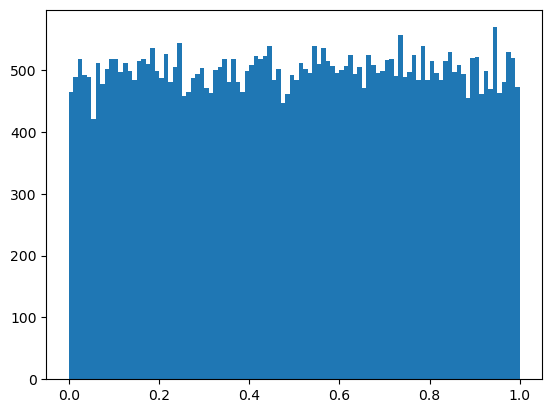

In [32]:
np.random.seed(123)
N = 50000
U = np.random.uniform(size=N)
plt.hist(U, bins=100)
plt.show()

#### And transform it into samples of $f(Z)$ 

we can evaluate the Hermite polynomial expansion to transform each $u_i$ into $f(u_i) = e^{\mu + \sigma z_i}$, where $z_i = F_Z^{-1}(u_i)$, using the polynomial expansion.

/tmp/ipykernel_59619/3803875415.py:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(h, 0, 1)[0]


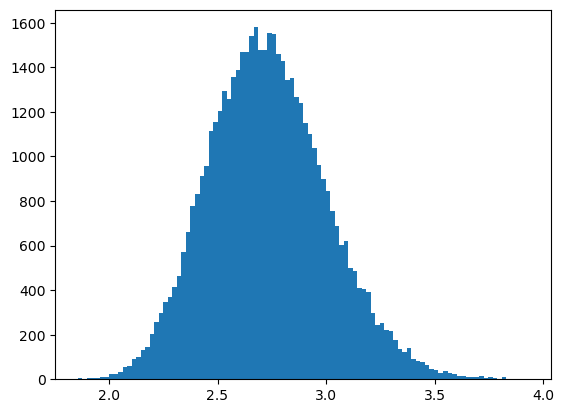

Sample mean: 2.7331888492589416
Sample variance: 0.0741113660623986


In [33]:
p = 10 
mu = 1.0
sigma = 0.1
f_inv = lambda u : lognorm.ppf(u, s=sigma, scale=np.exp(mu))
a = find_coef_u(f_inv, p)

f_tilde = []
for i in range(len(U)):
    f_tilde.append(eval_poly_u(U[i], a))
    
plt.hist(f_tilde, bins=100)
plt.show()

print('Sample mean:', np.mean(f_tilde))
print('Sample variance:', np.var(f_tilde))

<details>
  <summary>This compares to... </summary>

---


$$
E[f(Z)] = exp \left( \mu + \sigma^2/2 \right) = 2.731907
$$

which is equal to $a[0]$ and 

$$
Var(f(Z)) = \left[ e^{\sigma^2} - 1 \right] e^{2 \mu + \sigma^2} = 0.075008
$$

which is equal to 

$$
\sum_{j = 1}^{\infty} a_j^2 \langle H_j^2(z) \rangle = \sum_{j = 1}^{\infty} a_j^2 j! = a[1]^2 + 2 a[2]^2 + 6 a[3]^2 + 24 a[4]^2 + ... = 0.075008
$$

</details>

#### And transform into $Y \sim Beta(\alpha, \beta)$

/tmp/ipykernel_59619/3803875415.py:5: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return quad(h, 0, 1)[0]
/tmp/ipykernel_59619/3803875415.py:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(h, 0, 1)[0]


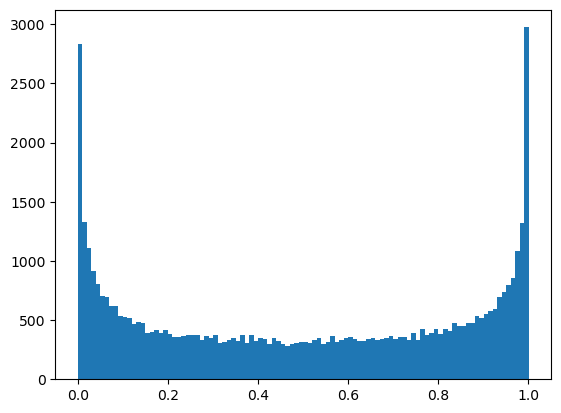

Sample mean: 0.5019653340480955
Sample variance: 0.12465895143810542


In [34]:
p = 30

mu = 1.0
sigma = 0.1
f_inv = lambda u : beta.ppf(u, a=0.5, b=0.5)

a = find_coef_u(f_inv, p)
f_tilde = []
for i in range(len(U)):
    f_tilde.append(eval_poly_u(U[i], a))
    
plt.hist(f_tilde, bins=100)
plt.show()

print('Sample mean:', np.mean(f_tilde))
print('Sample variance:', np.var(f_tilde))

<details>
  <summary>This compares to... </summary>

---

$$
E[Y] = \frac{\alpha}{\alpha + \beta} = 0.5
$$

$$
Var(y) = \frac{ \alpha \beta}{(\alpha + \beta)^2 (\alpha + \beta + 1)} = 0.125
$$

</details>